# Breast Cancer Detection II

### importing dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 
from skimage import io, color, exposure, filters
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [3]:
# GOOD for VGG16 / ResNet / MobileNet
from tensorflow.keras.applications.vgg16 import preprocess_input

In [4]:
# Check if TensorFlow can see your hardware
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU Available:  []


### Dataset Preprocessing

In [5]:
# Parameters
INPUT_SIZE = 128 # 264
BATCH_SIZE = 16 # 64, I was trying to prevent "ResourceExhaustedError"

SEED = 11
np.random.seed(SEED)
tf.random.set_seed(SEED)

path = "C:/Users/Gavela Maculuve/PycharmProjects/Projects_/CNN/BreastCancer/images"
trainpath = path + '/train'
validpath = path + '/valid'
testpath = path + '/test'

classes = ['Benign', 'Malignant']
NUMCLASSES = len(classes)

In [6]:
def preprocess(img):
    img = img.astype('float32')
    
    min_val = np.min(img)
    max_val = np.max(img)
    
    img = (img-min_val)/(max_val - min_val + 1e-7)
    img = img-0.5
    
    return img

In [7]:
img = io.imread(trainpath + '/Benign/36_1161539227_png.rf.4ffb84ae9f0a6aca49a2d5e2403de5d9.jpg')
gray = preprocess(img)
gray.shape

(640, 640, 3)

#### Data Augment

In [8]:
# Image Data Generator
# I believe that this creates the variability in the images, so they image are not uniform
train_datagen = ImageDataGenerator(
    rotation_range = 5,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    brightness_range = None,
    shear_range = 0.1,
    zoom_range = 0.05,
    fill_mode = "nearest",
    preprocessing_function = preprocess,
    horizontal_flip = True
    # vertical_flip = False,
    # data_format = None,
    # validation_split = 0.0,
    # dtype = None
    # rescale = 1./255,
    # cval = 0.0,
    # channel_shift_range = 0.0,
    # featurewise_center = False,
    # samplewise_center = False,
    # featurewise_std_normalization = False,
    # samplewise_std_normalization = False,
    # zca_epsilon = 1e-06,
)

val_datagen = ImageDataGenerator(
    # rescale = 1./255,
    preprocessing_function = preprocess # spin back
)


In [9]:
training_set = train_datagen.flow_from_directory(
    directory = trainpath,
    # subset = 'training',
    target_size = (INPUT_SIZE, INPUT_SIZE),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle = True,
    seed = SEED
)

validation_set = val_datagen.flow_from_directory(
    directory = validpath,
    # subset = 'validation',
    target_size = (INPUT_SIZE, INPUT_SIZE),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle = True,
    seed = SEED
)

Found 3111 images belonging to 2 classes.
Found 896 images belonging to 2 classes.


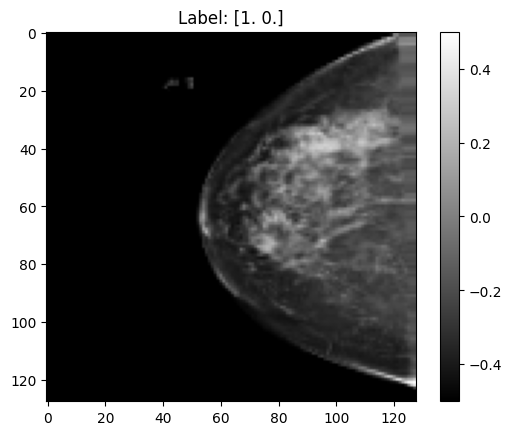

In [10]:
# Get one batch of images
images, labels = next(training_set)

# Show the first image in the batch
plt.imshow(images[0].reshape(128, 128), cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.colorbar() # This will show if values are between -0.5 and 0.5
plt.show()

### Model 1

In [11]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) -K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [12]:
model = Sequential() # this is like a stacker for the layers (lego bricks base)

model.add(InputLayer(shape = [INPUT_SIZE, INPUT_SIZE, 1])) # adding batch dimension

model.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
model.add(Dropout(0.2)) # prevent overfitting

model.add(Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
model.add(Dropout(0.3)) # prevent overfitting

model.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
model.add(Dropout(0.4)) # prevent overfitting

# model.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=2, padding = 'same')) # downsample the feature maps
# model.add(Dropout(0.2)) # prevent overfitting

# model.add(Flatten()) # 2D -> 1D
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(NUMCLASSES, activation = 'softmax'))

optimizer = Adam(learning_rate=1e-3, clipnorm=1.0)
model.compile(optimizer = optimizer, loss=focal_loss(gamma=2.0, alpha=0.25), metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             1

 Total params: 118,978 (464.76 KB)

 Trainable params: 118,274 (462.01 KB)

 Non-trainable params: 704 (2.75 KB)

#### Train one

In [13]:
epochs = 30
early_stop = EarlyStopping(monitor = "val_loss", patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 5, min_lr=1e-6)

history = model.fit(training_set, epochs = epochs, validation_data = validation_set, callbacks = early_stop)
model.save_weights("first-model-n-dec-31-2.weights.h5")
print("Saved model to disk after", epochs,"epochs.")

Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.5079 - loss: 6.5642 - val_accuracy: 0.4955 - val_loss: 3.0380
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 193s 990ms/step - accuracy: 0.4886 - loss: 4.1462 - val_accuracy: 0.5301 - val_loss: 2.9283
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 194s 997ms/step - accuracy: 0.5018 - loss: 3.3011 - val_accuracy: 0.4810 - val_loss: 2.8882
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 191s 981ms/step - accuracy: 0.5137 - loss: 2.9433 - val_accuracy: 0.4788 - val_loss: 2.7860
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.5339 - loss: 2.8179 - val_accuracy: 0.5413 - val_loss: 2.7574
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 191s 978ms/step - accuracy: 0.5342 - loss: 2.8119 - val_accuracy: 0.5312 - val_loss: 2.7529
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 192s 985ms/step - accuracy: 0.5416 - loss: 2.7790 - val_accuracy: 0.5000 - val_loss: 2.8256
Epoch 8/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 189s 968ms/step - accuracy: 0.5194 - loss:

In [14]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

#### Analysis

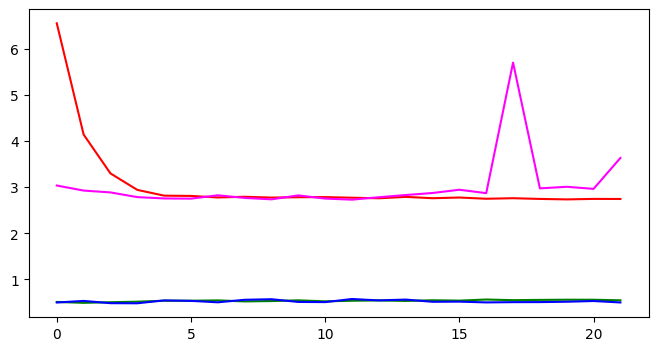

In [15]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['accuracy'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_accuracy'],color='blue')
plt.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step


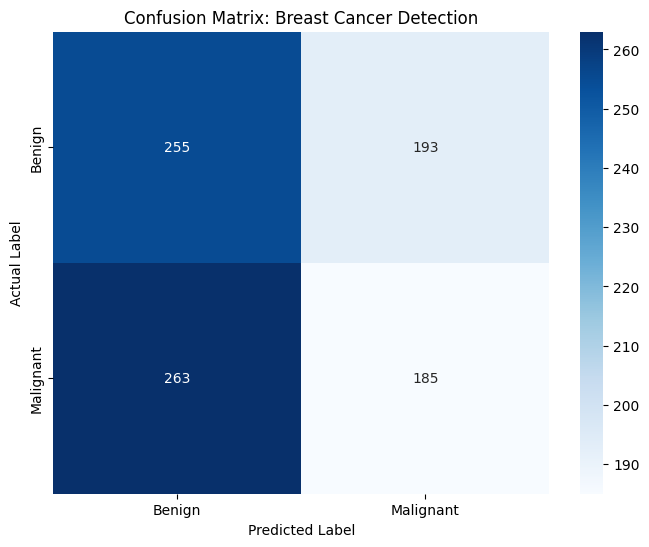

Classification Report
              precision    recall  f1-score   support

      Benign       0.49      0.57      0.53       448
   Malignant       0.49      0.41      0.45       448

    accuracy                           0.49       896
   macro avg       0.49      0.49      0.49       896
weighted avg       0.49      0.49      0.49       896



In [16]:
# 1. Get all true labels and predictions
# We turn off shuffle to ensure the labels match the predictions
validation_set.reset()
Y_pred = model.predict(validation_set)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_set.classes

# 2. Create the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix: Breast Cancer Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Detailed Report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=classes))

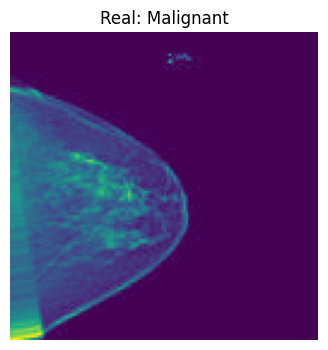

Real class: Malignant
--- Top Predictions ---
Malignant: 50.64%
Benign: 49.36%


In [17]:
# Get random image
class_name = np.random.choice(classes)
folder_path = os.path.join(trainpath, class_name)
file_name = np.random.choice([f for f in os.listdir(folder_path) if f.lower() != 'thumbs.db'])
image_path = os.path.join(folder_path, file_name)

# Load and preprocess
img_gray = io.imread(image_path, as_gray = True)
img_resized = cv2.resize(img_gray, (INPUT_SIZE,INPUT_SIZE))
img = preprocess(img_resized)
# plt.imshow(img)

# plt.plot(exposure.histogram(img)[0])
img_tensor = img.astype('float32')
img_tensor = np.expand_dims(img_tensor, axis=(0, -1))

# Print what the top predicted class is
preds = model.predict(img_tensor, verbose = 0).flatten()

# print("Output Probabilities:", preds)
order = np.argsort(preds)[::-1]
reverse_class_labels = {v: k for k, v in training_set.class_indices.items()}

plt.figure(figsize=(6,4))
plt.imshow(img_resized)#, cmap = 'gray')
plt.title(f"Real: {class_name}")
plt.axis('off')
plt.show()

print('Real class:', class_name)
print(f"--- Top Predictions ---")
for i in range(len(classes)):
    idx = order[i]
    print(f"{reverse_class_labels[idx]}: {preds[idx]:.2%}")

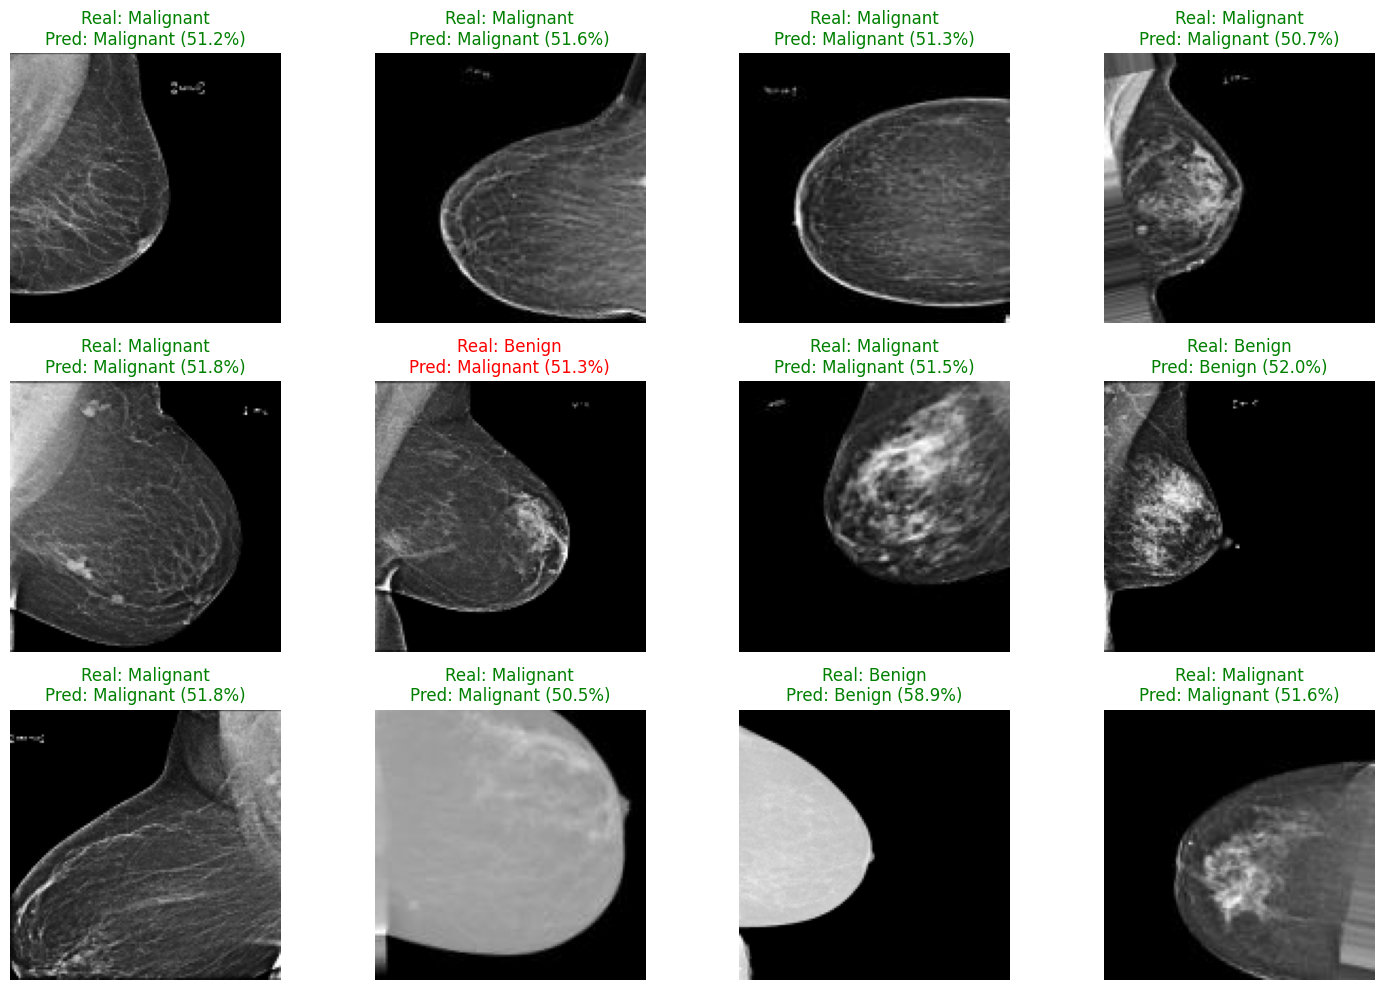

In [18]:
images, labels = next(validation_set) 

N = min(12, len(images)) # Show up to 12 images from the batch
fig = plt.figure(figsize=(15, 10))

for i in range(N):
    ax = fig.add_subplot(3, 4, i+1)
    
    # Get the actual dimensions of the image in the array
    h, w = images[i].shape[:2] 
    
    # Reshape dynamically: (1, height, width, 1)
    img_input = images[i].reshape(1, h, w, 1)
    
    # Make prediction
    pred = model.predict(img_input, verbose=0)
    
    # Convert one-hot labels back to text names
    real_label = classes[np.argmax(labels[i])] 
    pred_label = classes[np.argmax(pred)]
    confidence = np.max(pred) * 100
    
    # Display the mammogram
    ax.imshow(images[i].squeeze(), cmap='gray')
    
    # Color code the result: Green for match, Red for miss
    color = 'green' if real_label == pred_label else 'red'
    ax.set_title(f"Real: {real_label}\nPred: {pred_label} ({confidence:.1f}%)", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Model 2

In [19]:
from tensorflow.keras.applications import MobileNetV2

# Base model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, 
                         input_shape=(INPUT_SIZE, INPUT_SIZE, 3))
base_model.trainable = False  # Freeze expert layers initially

# Custom Input for Grayscale
inputs = Input(shape=(INPUT_SIZE, INPUT_SIZE, 1))
# Convert 1 channel to 3 channels so MobileNetV2 can process it
x = Concatenate()([inputs, inputs, inputs]) 
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)

model_3 = Model(inputs, outputs)

# 3. Aggressive Class Weights (The fix for 7% Malignant Recall)
# We tell the model that missing a Malignant case is 5x worse than a Benign one
class_weights = {0: 1.0, 1: 5.0} 

model_3.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

early_stop_3 = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr_3 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7)
checkpoint_3 = ModelCheckpoint('best_cancer_model_TL.keras', monitor='val_accuracy', save_best_only=True, verbose=1)


print("Starting training...")
history_3 = model_3.fit(
    training_set,
    epochs=30,
    validation_data=validation_set,
    class_weight=None,
    callbacks=[early_stop_3, reduce_lr_3, checkpoint_3]
)

Building MobileNetV2 Transfer Learning model...
Starting training...
Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.5008 - loss: 1.1333
Epoch 1: val_accuracy improved from None to 0.66629, saving model to best_cancer_model_TL.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 176s 697ms/step - accuracy: 0.5358 - loss: 1.0133 - val_accuracy: 0.6663 - val_loss: 0.6736 - learning_rate: 1.0000e-04
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.6001 - loss: 0.8459
Epoch 2: val_accuracy improved from 0.66629 to 0.66853, saving model to best_cancer_model_TL.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 140s 717ms/step - accuracy: 0.6088 - loss: 0.8164 - val_accuracy: 0.6685 - val_loss: 0.7531 - learning_rate: 1.0000e-04
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.6080 - loss: 0.7827
Epoch 3: val_accuracy did not improve from 0.66853
195/195 ━━━━━━━━━━━━━━━━━━━━ 120s 618ms/step - accuracy: 0.6374 - loss: 0.7408 - val_accuracy: 0.6540 - val_loss: 0.8336 - 

##### analysis

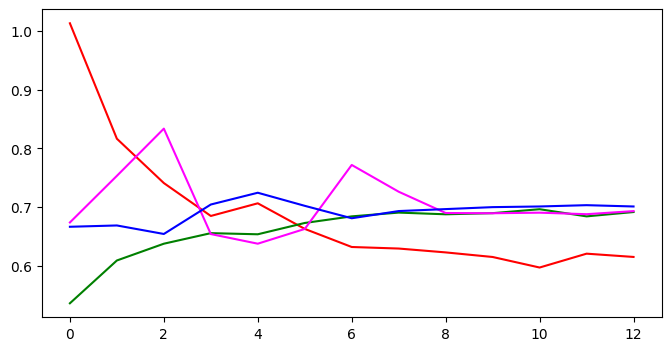

56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step


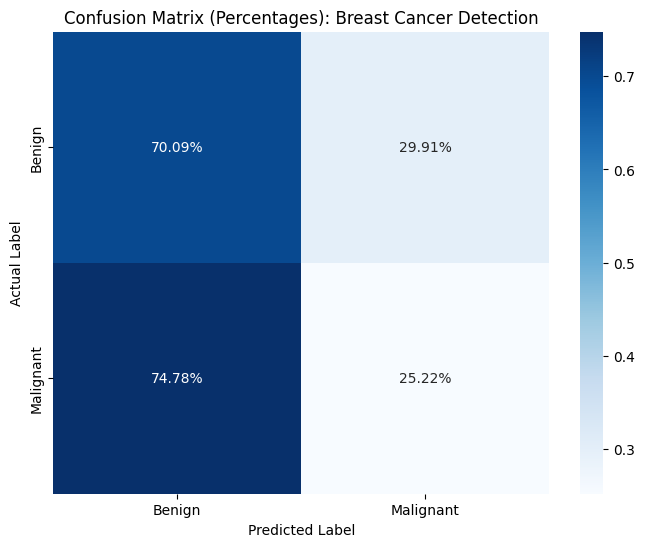

Classification Report
              precision    recall  f1-score   support

      Benign       0.48      0.70      0.57       448
   Malignant       0.46      0.25      0.33       448

    accuracy                           0.48       896
   macro avg       0.47      0.48      0.45       896
weighted avg       0.47      0.48      0.45       896



In [20]:
fig = plt.figure(figsize=(8,4))
plt.plot(history_3.history['loss'],color='red')
plt.plot(history_3.history['accuracy'],color='green')
plt.plot(history_3.history['val_loss'],color='magenta')
plt.plot(history_3.history['val_accuracy'],color='blue')
plt.show()

validation_set.reset()
Y_pred = model_3.predict(validation_set)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_set.classes

cm = confusion_matrix(y_true, y_pred)
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

# 3. Plotting with Percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_perc, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix (Percentages): Breast Cancer Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Detailed Report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=classes))

#### Final Analysis 

56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Malignant
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: Benign
Real class: Benign	Prediction: M

array([448., 448.])

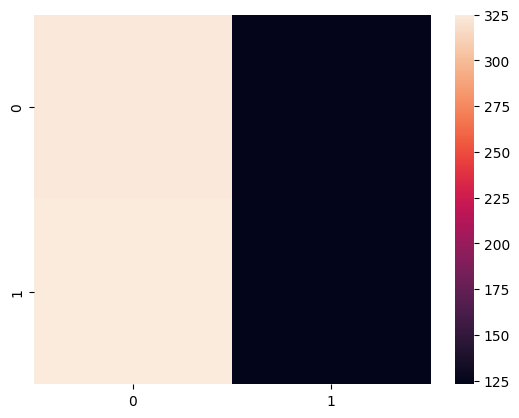

In [21]:
testset = validation_set

predictions = model_3.predict(testset)

order = np.argsort(predictions)
conf = np.zeros([NUMCLASSES, NUMCLASSES])
count = 0

classcounts = np.zeros(NUMCLASSES)
for i in range(predictions.shape[0]):
    index = order[i,:]
    index = index[::-1]
    print('Real class:', reverse_class_labels[testset.labels[i]], end='\t')
    print('Prediction:',reverse_class_labels[index[0]])
    conf[testset.labels[i],index[0]] += 1
    classcounts[testset.labels[i]]+=1
    if testset.labels[i]==index[0]:
        count+=1
sns.heatmap(conf)
print(count)
classcounts  

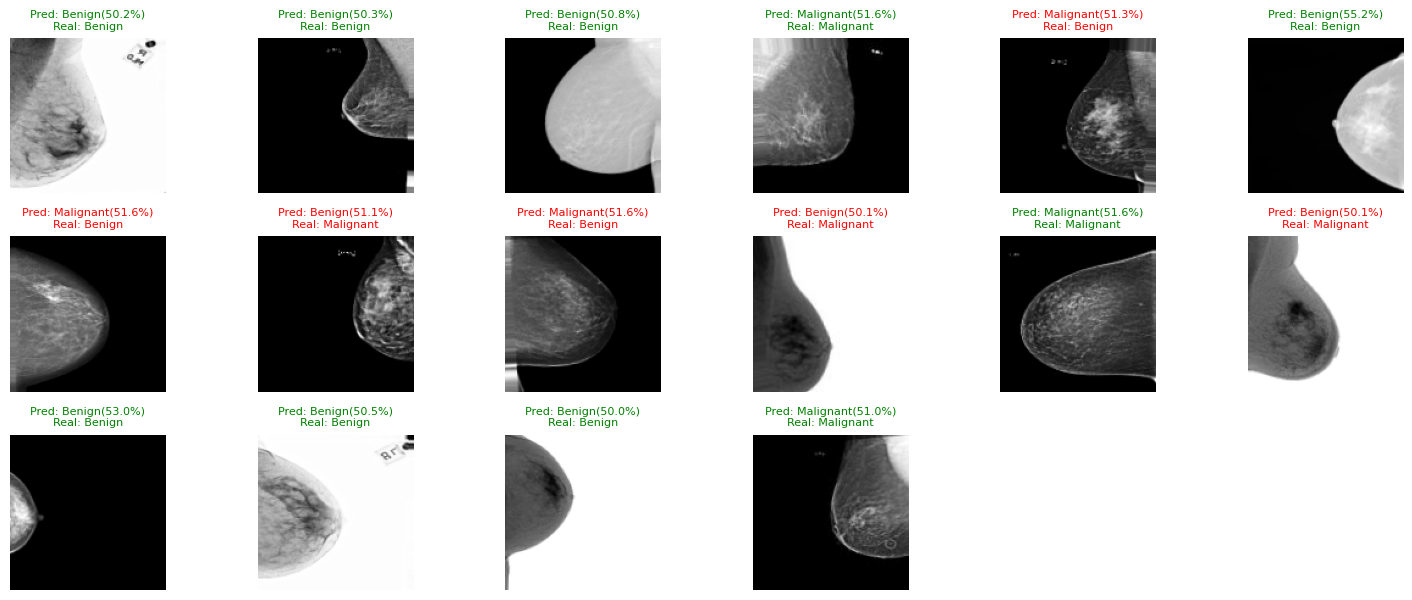

In [22]:
# Get one batch of training images and labels
images, labels = next(training_set)

# Limit to N images to show
N = 54
fig = plt.figure(figsize=(15, 18))

reverse_class_labels = {v: k for k, v in training_set.class_indices.items()}

for i in range(min(N, images.shape[0])):
    ax = fig.add_subplot(9, 6, i+1)

    # Prepare image for prediction
    img = images[i]
    img_input = img.reshape(1, INPUT_SIZE, INPUT_SIZE, 1)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_input, verbose=0)
    predicted_class_index = np.argmax(prediction)
    confidence = np.max(prediction) * 100
    
    # Get predicted label name
    realest_class_index = np.argmax(labels[i])
    realest_label_name = reverse_class_labels[realest_class_index]
    predicted_label_name = reverse_class_labels[predicted_class_index]
    

    # Show image with predicted label
    ax.imshow(img.squeeze(), cmap='gray')
    title_color = 'green' if predicted_class_index == realest_class_index else 'red'
    ax.set_title(f"Pred: {predicted_label_name}({confidence:.1f}%)\nReal: {realest_label_name}", fontsize=8, color = title_color)
    ax.axis('off')

plt.tight_layout()
plt.show()
